# Task A

In this task, we had to create a "transform" function which transforms unperformed beats time into a performed version.

In other words, given the `midi_score_annotations.txt` and `NAME_annotations.txt`, we need to create a function that transfers first column of the first file into the first column of the second file.

For the velocity, we use `*.mid` files and extract velocity from events. "Beat velocity" is defined as an average of the velocities of the events close to this beat. Event is close to the beat iff the difference between its onset in score and beat time is smaller than `0.5`. Then we again create a "transform" function.

In [4]:
%load_ext autoreload
%autoreload 2

from src.data import *
from src.plots import *
from src.estimators import *
from src.onset_distribution import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
df, json_data = get_dataset_metadata("Bach")

In [ ]:
df.head(2)

In [ ]:
# for the first time might take up to 5-10 min because of velocity
beats_list_dict = get_midi_performance_pairs(df, json_data, "4/4")

In [ ]:
train_beats_list_dict, test_beats_list_dict = train_test_split(beats_list_dict, test_size=0.2)

In [ ]:
print("Train / Test:", len(train_beats_list_dict["midi_beats_list"]), "/", len(test_beats_list_dict["midi_beats_list"]))

In [ ]:
midi_beats_list = test_beats_list_dict["midi_beats_list"]
velocity_beats_list = test_beats_list_dict["velocity_beats_list"]
performance_beats_list = test_beats_list_dict["performance_beats_list"]
perf_velocity_beats_list = test_beats_list_dict["perf_velocity_beats_list"]

performance_beats_estimated_list_dict = {}
perf_velocity_beats_estimated_list_dict = {}

In [ ]:
# random estimate
performance_beats_estimated_list, velocity_beats_estimated_list = get_estimator_predictions(train_beats_list_dict,
                                                                                            test_beats_list_dict,
                                                                                            estimator_type="random")

performance_beats_estimated_list_dict["random"] = performance_beats_estimated_list
perf_velocity_beats_estimated_list_dict["random"] = velocity_beats_estimated_list

In [ ]:
# linear estimate
performance_beats_estimated_list, velocity_beats_estimated_list = get_estimator_predictions(train_beats_list_dict,
                                                                                            test_beats_list_dict,
                                                                                            estimator_type="linear")

performance_beats_estimated_list_dict["linear"] = performance_beats_estimated_list
perf_velocity_beats_estimated_list_dict["linear"] = velocity_beats_estimated_list

In [ ]:
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

warnings.filterwarnings("ignore", category=RuntimeWarning) 


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0] = plot_average_transfer_function(axes[0], midi_beats_list,
                                        midi_beats_list, # unperformed_beats_list
                                        performance_beats_list,
                                        performance_beats_estimated_list_dict,
                                        performance_type="time"
)

axes[1] = plot_average_transfer_function(axes[1], midi_beats_list,
                                        velocity_beats_list, # unperformed_beats_list
                                        perf_velocity_beats_list,
                                        perf_velocity_beats_estimated_list_dict,
                                        performance_type="velocity"
)
plt.savefig("data/task_A.pdf", dpi=600)

# Task B

Use `src.data.get_events_table_from_score`

In [6]:
from pathlib import Path
# DATASET_PATH = Path("./data/asap-dataset")
# We analyse Bach's Fugues (or other?)
corpus = DATASET_PATH / "Beethoven" / "Piano_Sonatas"

In [ ]:

unique_signatures = list_all_time_signatures(corpus)

get_average_distribution_given_time_signature(corpus, (4,4), 4)
get_average_distribution_given_time_signature(corpus, (3,4), 4)
get_average_distribution_given_time_signature(corpus, (6,8), 2)

In [16]:
#df, json = classical()
styles = ["Baroque", "Classical", "Romantism", "Impressionism", "20th Century Russian"]
styles_composers = [baroque_composers, classical_composers, romantic_composers, impressionist_composers, late_russian_composers]
composers = []
for style_composers in styles_composers:
    composers.extend(style_composers)
expr_by_composer = composer_expressiveness_analysis(composers)
expr_by_style = style_expressiveness_analysis(styles_composers)


computing averages:: 100%|██████████| 16/16 [00:32<00:00,  2.05s/it]


all composers = ['Bach', 'Mozart', 'Haydn', 'Beethoven', 'Brahms', 'Chopin', 'Liszt', 'Schubert', 'Schumann', 'Glinka', 'Debussy', 'Ravel', 'Balakirev', 'Prokofiev', 'Rachmaninoff', 'Scriabin']


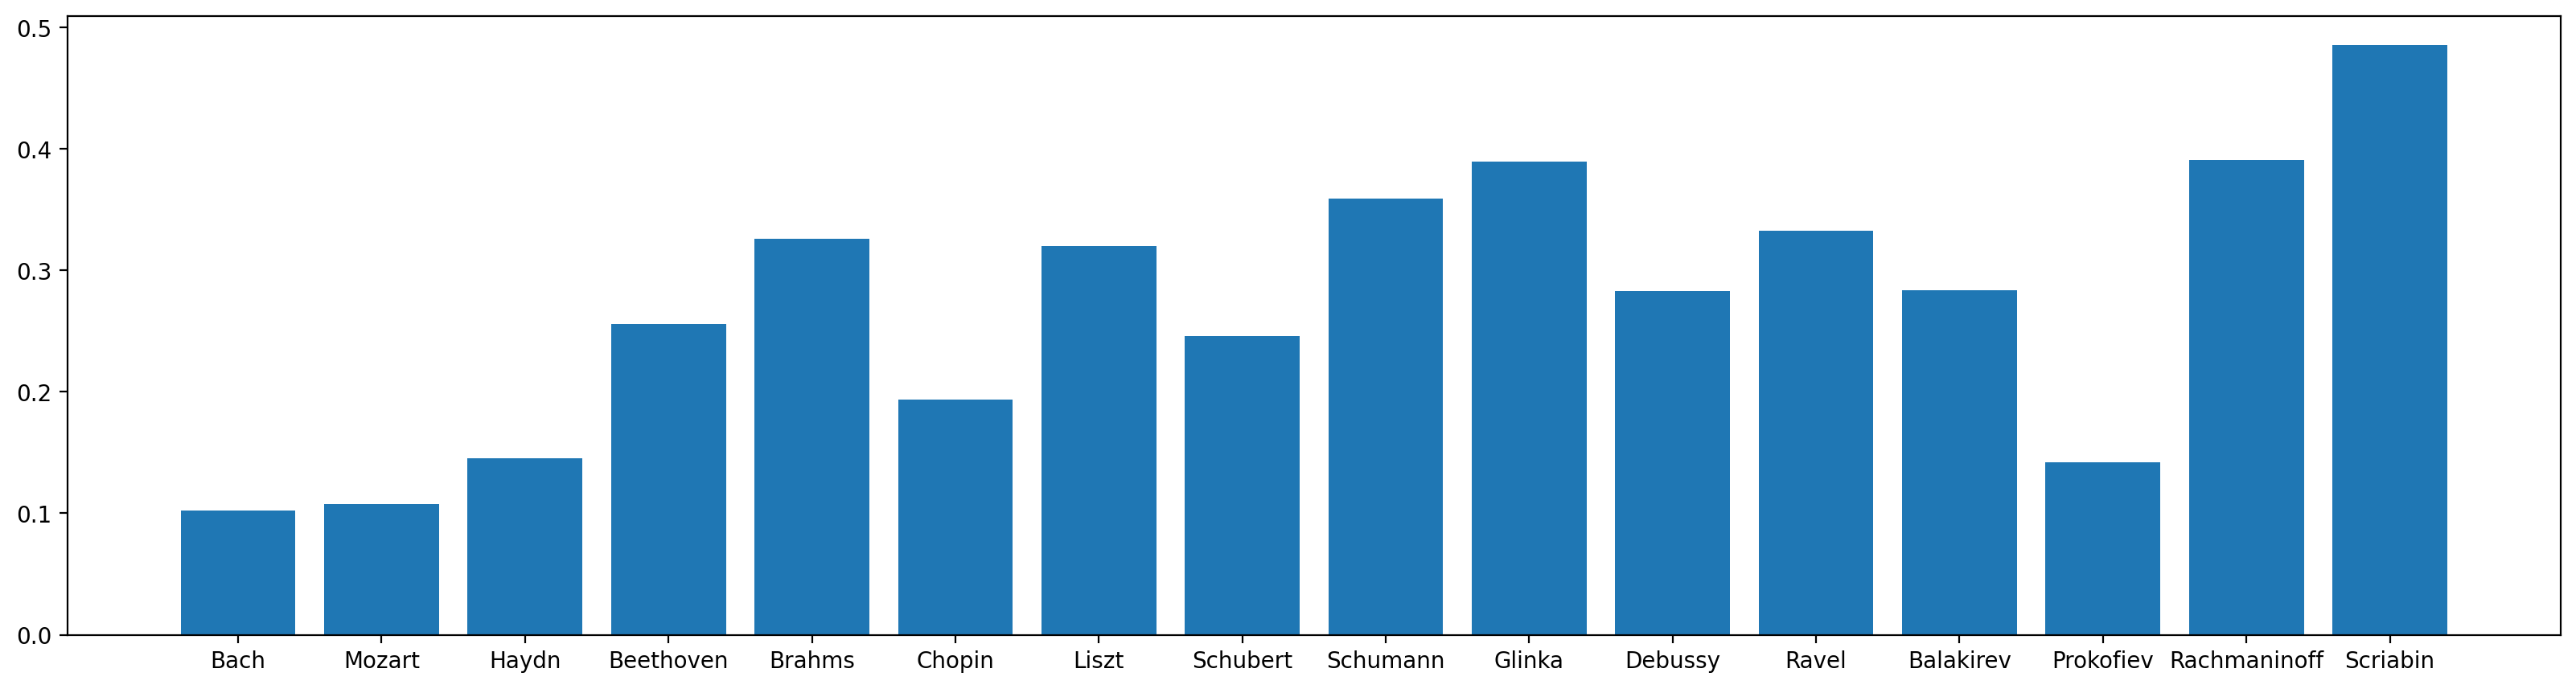

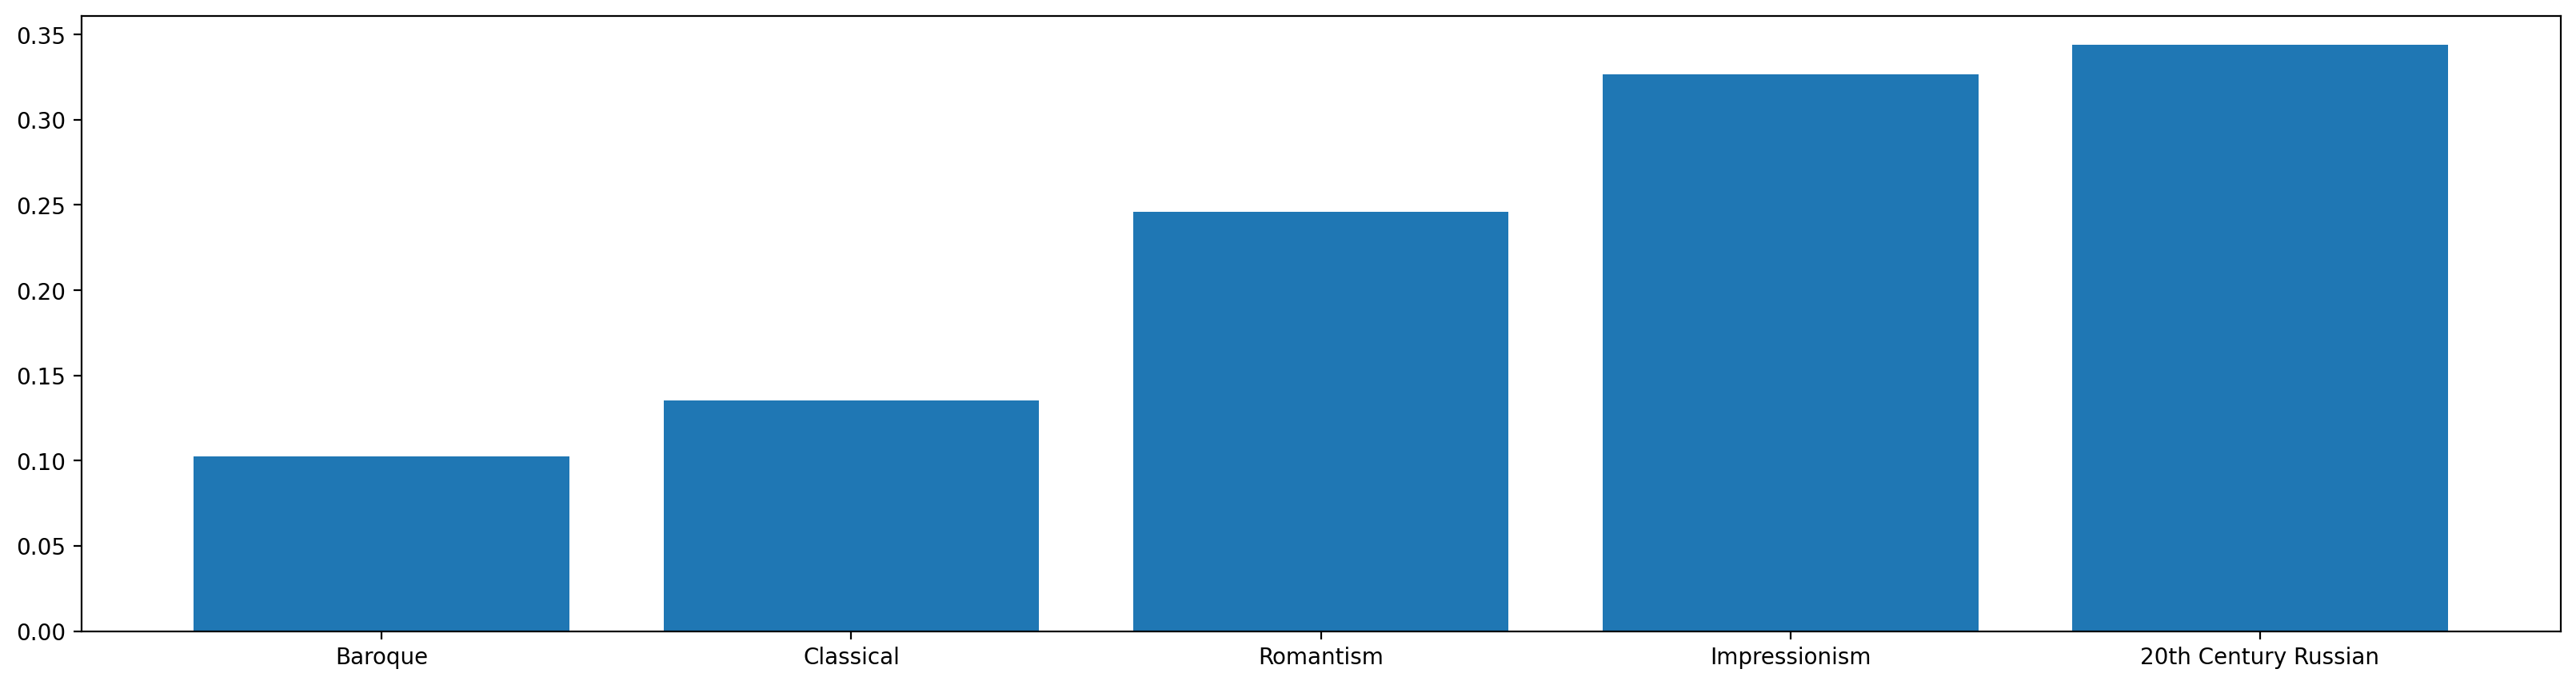

In [17]:
plot_composer_analysis(composers, expr_by_composer)
plot_style_analysis(styles, expr_by_style)

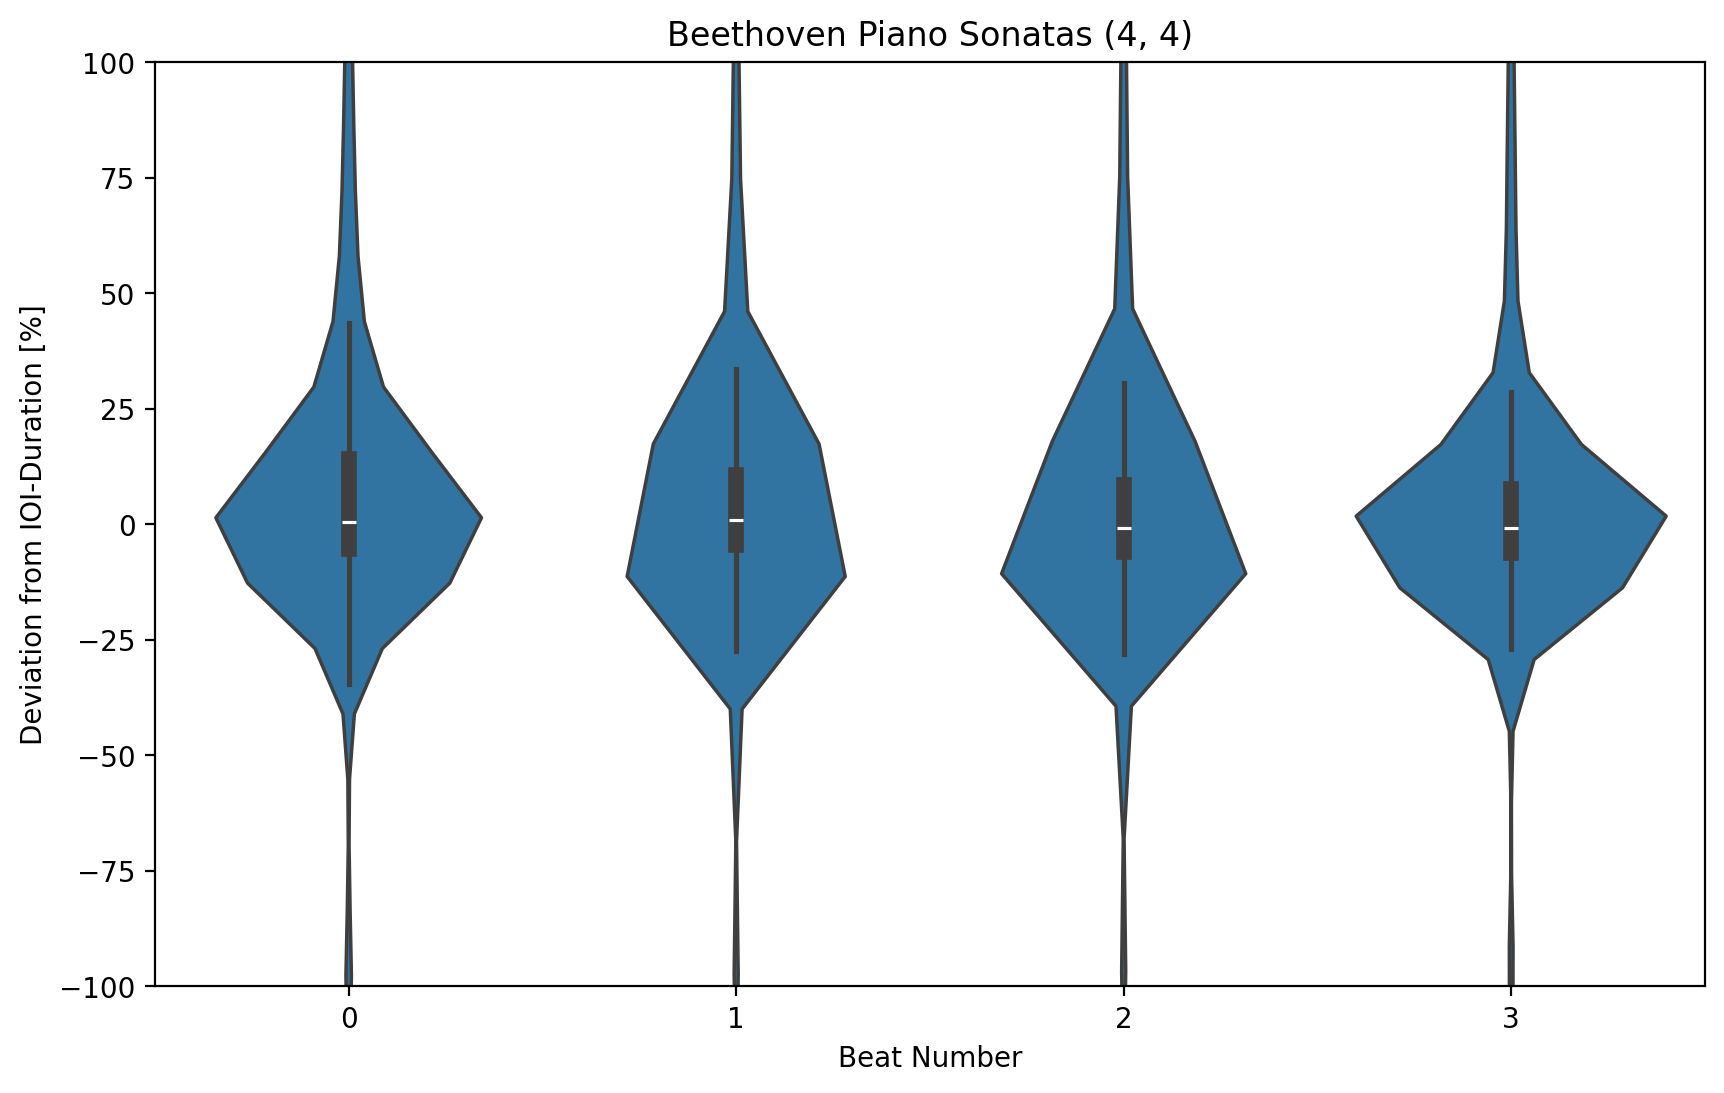

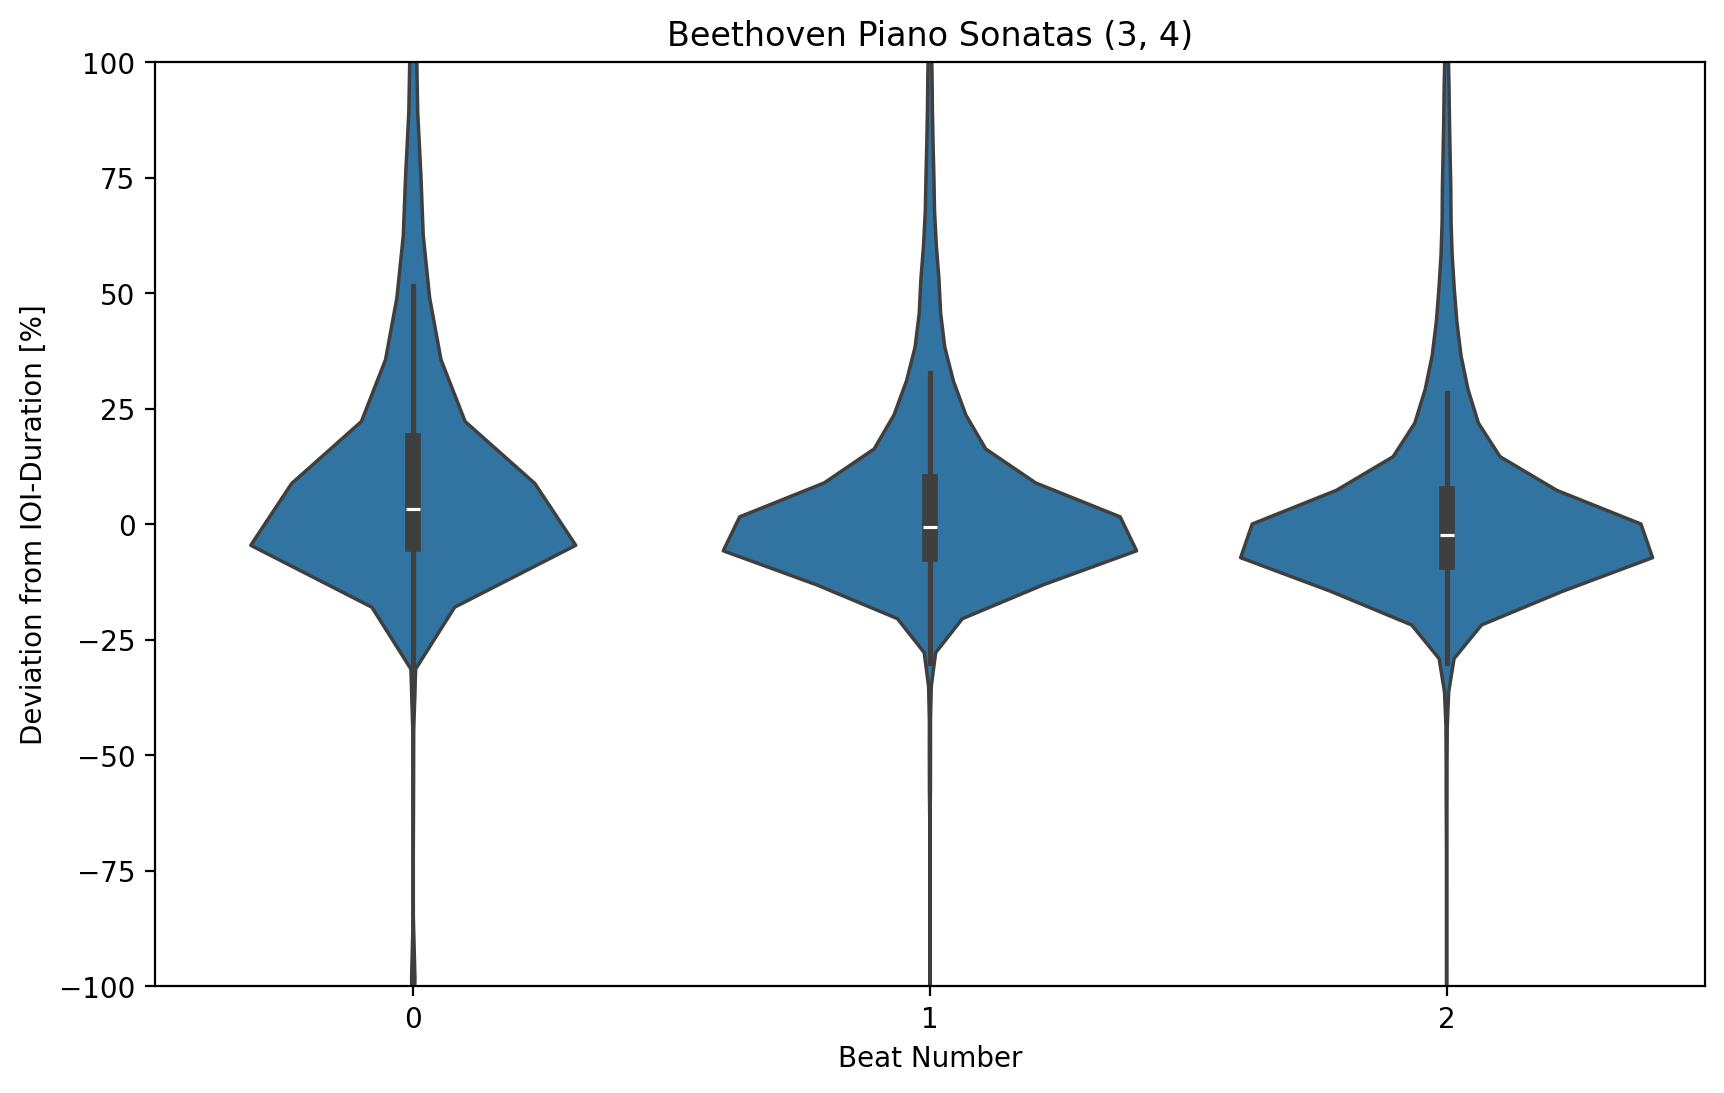

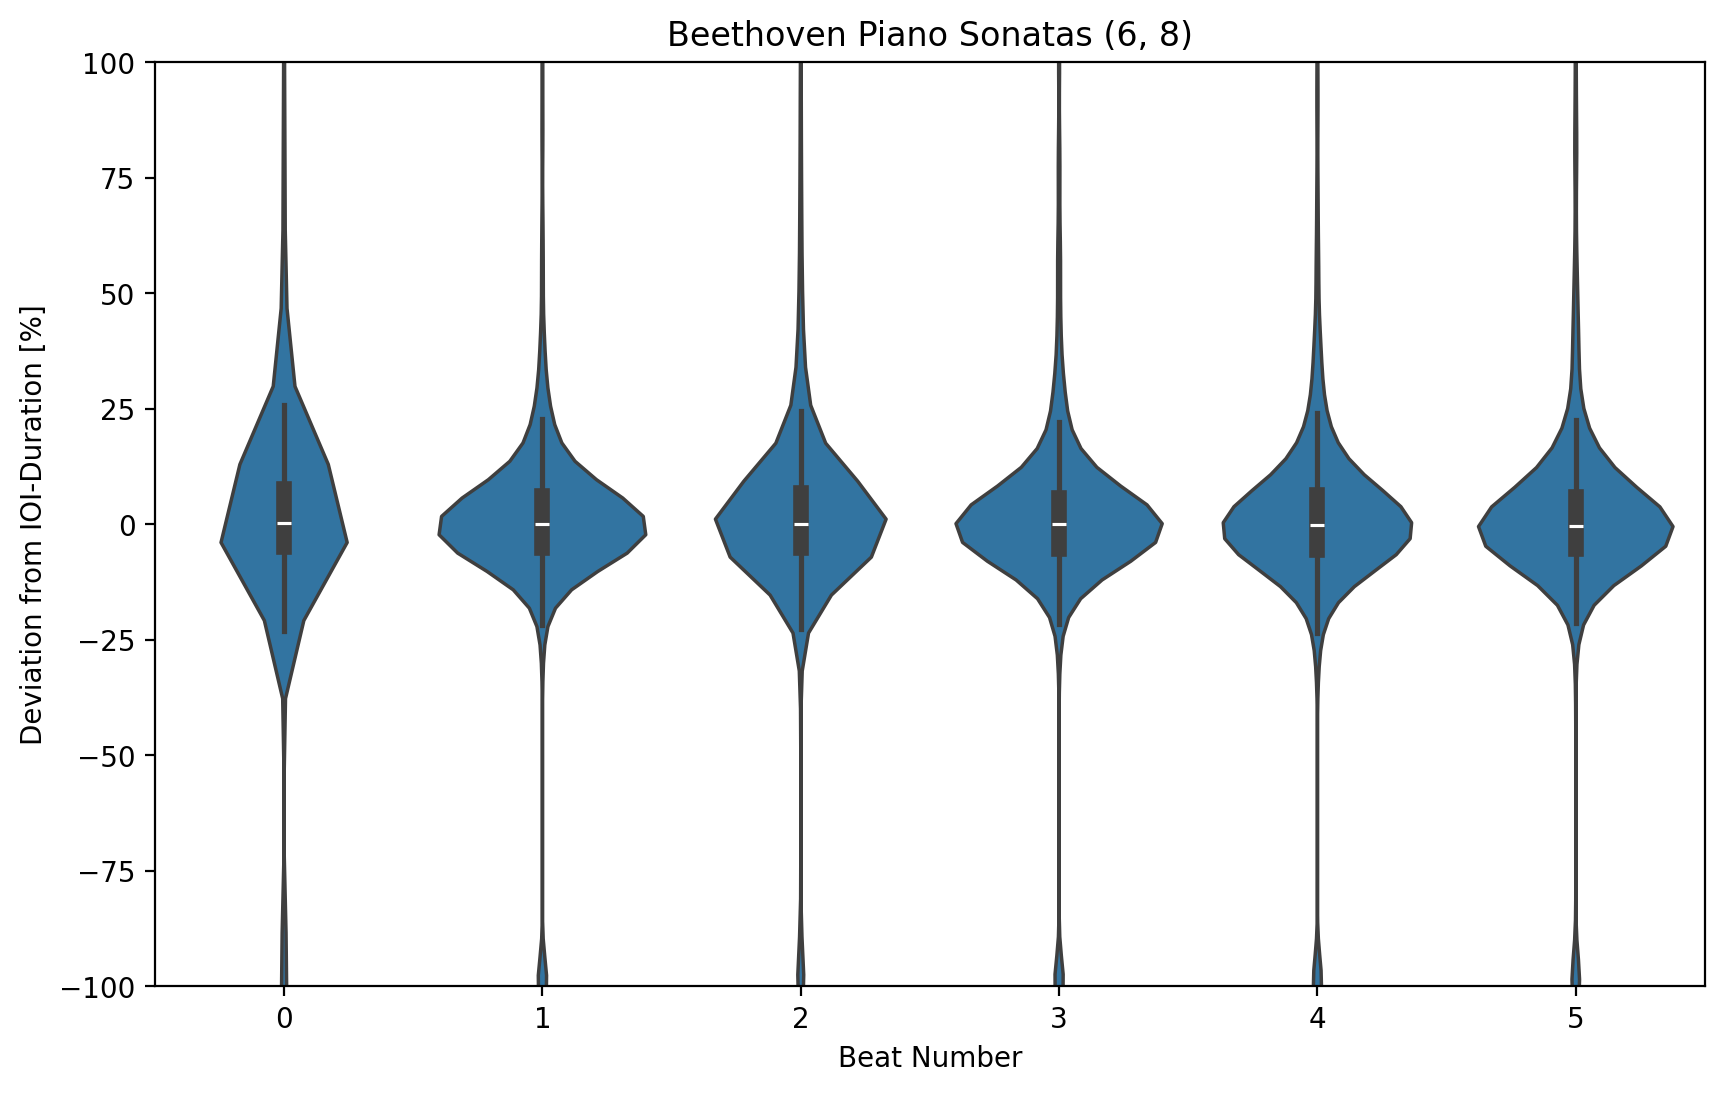

In [15]:
for time_signature in [(4,4), (3,4), (6,8)]:
    beat = time_signature[0]
    bar = time_signature[1]
    pieces = collect_pieces_with_time_signature(corpus, [beat, bar])
    beat_deviations = combine_beat_deviations(pieces, beat)
    plot_violins(beat_deviations, f'Beethoven Piano Sonatas {time_signature}', (-100, 100))
    

In [100]:
# Check where high deviation values (>2) are coming from
# for piece in pieces:
#     interval = annotation_to_inter_onset_intervals(piece)
#     deviation = (interval - interval.median())/interval.median()
#     if sum(deviation[deviation > 2]):
#         print(piece.split('/')[-4:])
#         print(deviation[deviation > 2])
#         input('press enter to continue')
        

['Beethoven', 'Piano_Sonatas', '11-1', 'DeTurck01_annotations.txt']
500    2.142621
dtype: float64
['Beethoven', 'Piano_Sonatas', '11-1', 'LiYZ03M_annotations.txt']
500    2.366712
dtype: float64
['Beethoven', 'Piano_Sonatas', '11-1', 'NAKAJI01_annotations.txt']
500    2.355119
dtype: float64
['Beethoven', 'Piano_Sonatas', '11-1', 'ZhaoK02M_annotations.txt']
500    2.50529
dtype: float64
['Beethoven', 'Piano_Sonatas', '14-3', 'Meek03_annotations.txt']
458    2.143542
459    2.143542
460    2.143542
662    2.976283
663    2.976283
664    2.976283
745    9.994684
746    6.947227
747    6.947227
748    6.947227
dtype: float64
['Beethoven', 'Piano_Sonatas', '17-1', 'KaszoS09M_annotations.txt']
1      7.815359
2      7.815359
3      6.055167
4      9.498814
5      3.476426
         ...   
992    2.045564
993    2.268590
994    2.268590
995    2.654683
996    2.827342
Length: 106, dtype: float64


KeyboardInterrupt: Interrupted by user

In [16]:
pieces = collect_pieces_with_time_signature(corpus, [4, 4])
beat_deviations = combine_beat_deviations(pieces, beat)

In [28]:
beat_deviations[beat_deviations['Beat']==0]['Deviation'].median()
beat_deviations[beat_deviations['Beat']==1]['Deviation'].median()

0.11757972543872561